<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9
## <center> Анализ временных рядов

In [1]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)
import numpy as np



def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

1.12.9


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv('data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [8]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [5]:
from fbprophet import Prophet

In [6]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [9]:

m = Prophet()
m.fit(train_df)

In [10]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [11]:
forecast = m.predict(future)
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
378,2016-01-16,1.073446,2946.748331,-461.131891,-461.131891,2946.748242,2946.748460,2144.002085,2831.524616,-860.441386,-860.441386,-860.441386,399.309494,399.309494,399.309494,-461.131891,2485.616440
379,2016-01-17,1.076271,2949.752360,-303.591130,-303.591130,2949.752264,2949.752497,2267.839997,2990.053435,-720.143785,-720.143785,-720.143785,416.552654,416.552654,416.552654,-303.591130,2646.161230
380,2016-01-18,1.079096,2952.756388,713.816039,713.816039,2952.756288,2952.756535,3340.782662,4024.025024,282.577995,282.577995,282.577995,431.238044,431.238044,431.238044,713.816039,3666.572427
381,2016-01-19,1.081921,2955.760417,981.307220,981.307220,2955.760311,2955.760570,3597.799085,4291.382697,538.054284,538.054284,538.054284,443.252936,443.252936,443.252936,981.307220,3937.067637
382,2016-01-20,1.084746,2958.764445,874.202169,874.202169,2958.764335,2958.764607,3477.771163,4216.651288,421.678742,421.678742,421.678742,452.523426,452.523426,452.523426,874.202169,3832.966614


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

# 3832.966614

In [12]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [17]:
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print("MAPE:",np.mean(abs(cmp_df[-predictions:]['p'])), "MAE:",np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE: 38.38827176223028 MAE: 713.0110429704669


**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

# MAPE: 38.38827176223028 MAE: 713.0110429704669

## Предсказываем с помощью ARIMA

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [7]:
train_df = train_df.fillna(14).set_index('ds')

Критерий Дики-Фуллера: p=0.107392


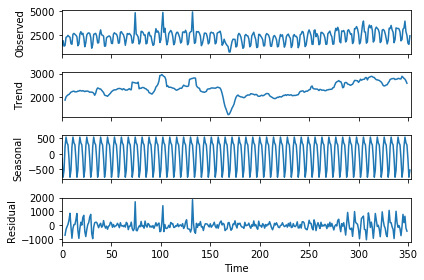

In [10]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

# Критерий Дики-Фуллера: p=0.107392,исходный ряд стационарным не является,гипотеза о единичном корне не отверглась

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

Оптимальный параметр преобразования Бокса-Кокса: 0.732841
Критерий Дики-Фуллера: p=0.107392


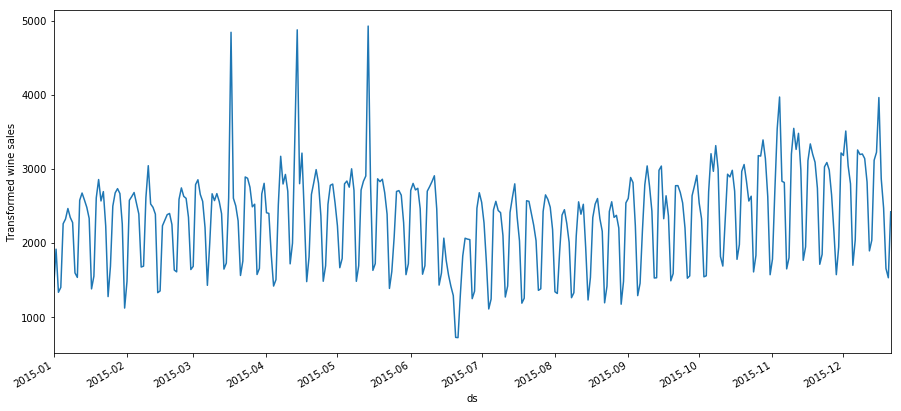

In [11]:
train_df.index = pd.to_datetime(train_df.index)
train_df['y_box'], lmbda = stats.boxcox([1 if x == 0 else x for x in train_df['y']])
plt.figure(figsize=(15,7))
train_df.y.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

In [12]:
train_df['y_box_diff'] = train_df.y_box - train_df.y_box.shift(7)
plt.figure(figsize=(15,10))
#sm.tsa.seasonal_decompose(train_df.y_box_diff[12:].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_box_diff[8:])[1])

Критерий Дики-Фуллера: p=0.000000


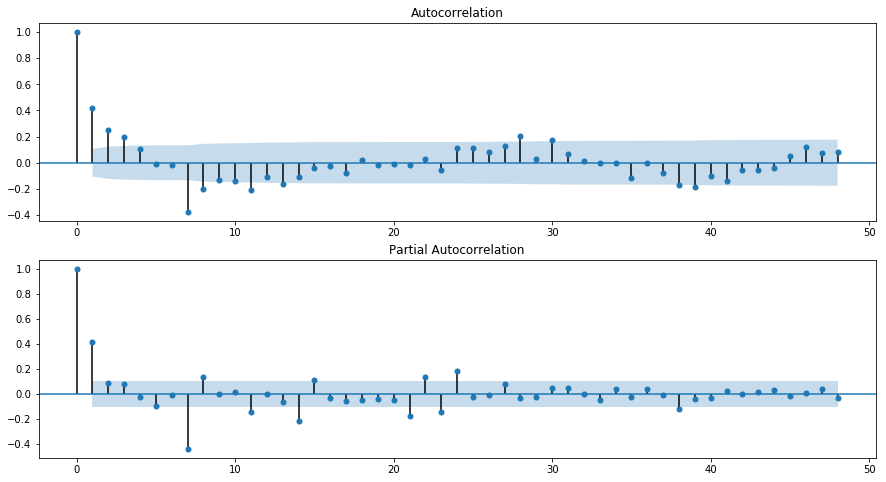

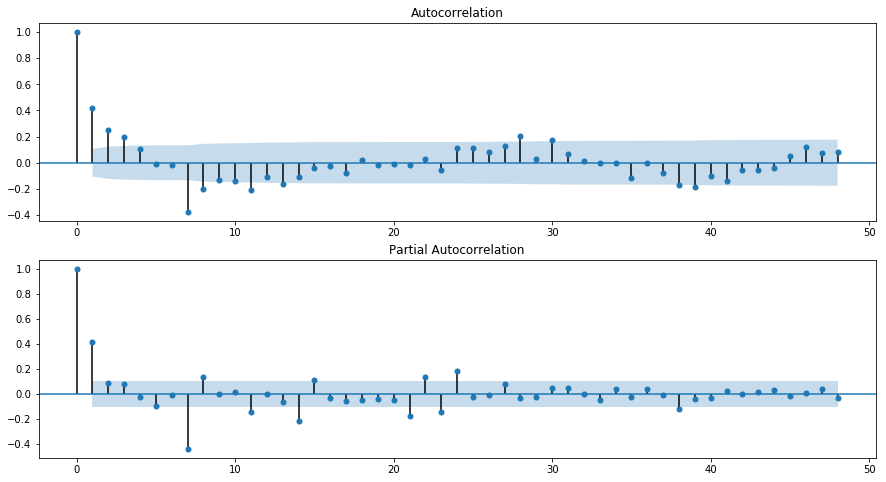

In [13]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_box_diff[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_box_diff[13:].values.squeeze(), lags=48, ax=ax)

In [ ]:
ps = range(0, 4)
d=1
qs = range(0, 5)
Ps = range(0, 7)
D=1
Qs = range(0, 2)

In [45]:
ps = range(0, 3)
d= 1
qs = range(0, 4)
Ps = range(0, 5)
D= 1
Qs = range(0, 3)

    parameters          aic
84   (1, 1, 3, 1)  3555.913327
86   (1, 1, 4, 0)  3556.348870
83   (1, 1, 3, 0)  3556.712164
129  (2, 1, 3, 1)  3557.889124
87   (1, 1, 4, 1)  3557.902643
In [51]:

print(best_model.summary())
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 7)   Log Likelihood               -1770.957
Date:                           Mon, 15 May 2017   AIC                           3555.913
Time:                                   10:31:36   BIC                           3582.979
Sample:                               01-01-2015   HQIC                          3566.683
                                    - 12-21-2015                                         
Covariance Type:                             opg                    

In [52]:
ps = range(0, 3)
d= 0
qs = range(0, 4)
Ps = range(0, 5)
D= 1
Qs = range(0, 3)
parameters          aic
173  (2, 3, 3, 0)  3554.782896
174  (2, 3, 3, 1)  3556.104846
176  (2, 3, 4, 0)  3556.333028
98   (1, 2, 3, 0)  3556.880030
99   (1, 2, 3, 1)  3557.003104
In [56]:

print(best_model.summary())
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(2, 0, 3)x(3, 1, 0, 7)   Log Likelihood               -1768.391
Date:                           Mon, 15 May 2017   AIC                           3554.783
Time:                                   10:38:28   BIC                           3589.581
Sample:                               01-01-2015   HQIC                          3568.629
                                    - 12-21-2015                                         
Covariance Type:                             opg                     

In [57]:
ps = range(0, 3)
d= 1
qs = range(0, 4)
Ps = range(0, 5)
D= 0
Qs = range(0, 3)

41  (0, 3, 4, 0)  3631.601641
43  (0, 3, 4, 2)  3638.279996
36  (0, 3, 2, 1)  3644.433837
34  (0, 3, 1, 2)  3647.795141
38  (0, 3, 3, 0)  3650.588042
In [61]:

print(best_model.summary())
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(0, 1, 3)x(4, 0, 0, 7)   Log Likelihood               -1807.801
Date:                           Mon, 15 May 2017   AIC                           3631.602
Time:                                   10:45:13   BIC                           3662.533
Sample:                               01-01-2015   HQIC                          3643.910
                                    - 12-21-2015                                         
Covariance Type:                             opg          

In [62]:
ps = range(0, 3)
d= 0
qs = range(0, 4)
Ps = range(0, 5)
D= 0
Qs = range(0, 3)

   parameters          aic
35  (1, 1, 1, 1)  3660.484561
27  (1, 0, 1, 1)  3662.025930
51  (2, 0, 1, 1)  3662.392232
38  (1, 1, 2, 1)  3662.396044
36  (1, 1, 1, 2)  3663.872281
In [66]:

print(best_model.summary())
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -1825.242
Date:                           Mon, 15 May 2017   AIC                           3660.485
Time:                                   10:46:48   BIC                           3679.817
Sample:                               01-01-2015   HQIC                          3668.177
                                    - 12-21-2015                                         
Covariance Type:                             opg                    

In [68]:
ps = range(0, 3)
d= 1
qs = range(0, 4)
Ps = range(0, 5)
D= 2
Qs = range(0, 3)

      parameters          aic
69  (1, 1, 4, 1)  3533.500168
81  (1, 2, 4, 1)  3534.480844
78  (1, 2, 3, 1)  3534.570948
30  (0, 2, 3, 1)  3534.985443
70  (1, 1, 4, 2)  3535.103454
In [72]:

print(best_model.summary())
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(1, 1, 1)x(4, 2, 1, 7)   Log Likelihood               -1758.750
Date:                           Mon, 15 May 2017   AIC                           3533.500
Time:                                   10:56:34   BIC                           3564.432
Sample:                               01-01-2015   HQIC                          3545.808
                                    - 12-21-2015                                         
Covariance Type:                             opg                                         

In [73]:
ps = range(0, 3)
d= 0
qs = range(0, 4)
Ps = range(0, 5)
D= 2
Qs = range(0, 3)

parameters          aic
52  (1, 0, 4, 1)  3529.782438
49  (1, 0, 3, 1)  3530.524248
53  (1, 0, 4, 2)  3531.455541
50  (1, 0, 3, 2)  3531.803162
41  (0, 3, 4, 1)  3537.609848
In [77]:

print(best_model.summary())
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(1, 0, 0)x(4, 2, 1, 7)   Log Likelihood               -1757.891
Date:                           Mon, 15 May 2017   AIC                           3529.782
Time:                                   10:59:32   BIC                           3556.848
Sample:                               01-01-2015   HQIC                          3540.552
                                    - 12-21-2015                                         
Covariance Type:                             opg              

In [80]:
from itertools import product

parameters = product(d,D,Qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [84]:
p = 1
ds = range(0, 2)
q = 2
P = 3
Ds = range(0, 3)
Qs = range(0, 2)

from itertools import product
parameters = product(Ds, ds, Qs)
parameters_list = list(parameters)
len(parameters_list)


from tqdm import tqdm
results = []
best_aic = float("inf")



for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y'], order=(p, param[1], q), 
                                        seasonal_order=(P, param[0], param[2], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

  0%|          | 0/12 [00:00<?, ?it/s]

wrong parameters: (0, 0, 0)
wrong parameters: (0, 0, 1)
wrong parameters: (0, 1, 0)
wrong parameters: (0, 1, 1)


 42%|████▏     | 5/12 [00:02<00:03,  2.32it/s]/home/dz/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 50%|█████     | 6/12 [00:04<00:06,  1.04s/it]/home/dz/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning:

invalid value encountered in sqrt

 67%|██████▋   | 8/12 [00:05<00:02,  1.54it/s]/home/dz/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

100%|██████████| 12/12 [00:17<00:00,  1.85s/it]


In [85]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True))

  parameters          aic
5  (2, 0, 1)  4975.481889
0  (1, 0, 0)  5022.312525
1  (1, 0, 1)  5022.982338
4  (2, 0, 0)  5068.979017
2  (1, 1, 0)          NaN
3  (1, 1, 1)          NaN
6  (2, 1, 0)          NaN
7  (2, 1, 1)          NaN


In [ ]:
D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1
D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1
D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

In [86]:
p = 1
ds = 0
q = 2
P = 3
Ds = 0
Qs = 0

In [40]:
import statsmodels.api as sm

In [28]:
import statsmodels as sm

In [32]:
sm.__version__

AttributeError: module 'statsmodels.api' has no attribute '__version__'

In [ ]:
D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1
D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1
D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

In [89]:
ps = range(1, 2)
d=0
qs = range(2, 3)
Ps = range(3, 4)
D=1
Qs = range(0, 1)
3556.88003/5022.312525


In [97]:
ps = range(1, 2)
d=1
qs = range(2, 3)
Ps = range(3, 4)
D=2
Qs = range(1, 2)
3534.570948/nan

In [104]:
ps = range(1, 2)
d=1
qs = range(2, 3)
Ps = range(3, 4)
D=1
Qs = range(1, 2)
3557.952366/nan

In [121]:
ps = range(1, 2)
d=0
qs = range(2, 3)
Ps = range(3, 4)
D=0
Qs = range(0, 1)

In [122]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

1

In [125]:
%%time
results = []
best_aic = float("inf")



for param in parameters_list:
    print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        %time model=sm.tsa.statespace.SARIMAX(train_df.y, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    #except:
        #print('wrong parameters:', param)
        #continue
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(1, 2, 3, 0)
wrong parameters: (1, 2, 3, 0)


NameError: name 'warnings' is not defined

In [126]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

In [127]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(1, 1, 2)x(3, 1, 1, 7)   Log Likelihood               -1770.976
Date:                           Mon, 15 May 2017   AIC                           3557.952
Time:                                   17:32:10   BIC                           3588.884
Sample:                               01-01-2015   HQIC                          3570.260
                                    - 12-21-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4798   8.05e+04   5.96e-06      1.000   -1.58e+05    1.58e+05
ma.L1         -0.9872   8.66e+04  -1.14e-05